# Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn import (datasets,
                     dummy,
                     metrics,
                     model_selection as skms,
                     multiclass as skmulti,
                     naive_bayes,
                     neighbors,
                     preprocessing as skpre)

In [3]:
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

# Multi-class Metric Averages

In [4]:
iris = datasets.load_iris()

tts = skms.train_test_split(iris.data, iris.target, 
                            test_size=.33, random_state=21)

(iris_train_ftrs, iris_test_ftrs, 
 iris_train_tgt,  iris_test_tgt) = tts

In [5]:
iris_preds = (neighbors.KNeighborsClassifier()
                      .fit(iris_train_ftrs, iris_train_tgt)
                      .predict(iris_test_ftrs))

In [6]:
print(metrics.classification_report(iris_test_tgt, 
                                    iris_preds))
# verify sums-across-rows
cm = metrics.confusion_matrix(iris_test_tgt, iris_preds)
print(cm)
print("row counts equal support:", cm.sum(axis=1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.89      0.94      0.91        17
           2       0.93      0.87      0.90        15

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50

[[18  0  0]
 [ 0 16  1]
 [ 0  2 13]]
row counts equal support: [18 17 15]


In [7]:
macro_prec = metrics.precision_score(iris_test_tgt, 
                                     iris_preds, 
                                     average='macro')
print("macro:", macro_prec)

macro: 0.9391534391534391


In [8]:
cm = metrics.confusion_matrix(iris_test_tgt, iris_preds)
print(cm)
n_labels = len(iris.target_names)

# remember: 
# precision is about column of our confusion matrix
# diagonal is where we are correct
# 'macro' means "average over all classes"
# each_class_precision(correct     /   full column) [ add, divide n --> average]
manual_macro_prec   = (np.diag(cm) / cm.sum(axis=0)).sum() / n_labels
print(manual_macro_prec)
print("should equal 'macro avg':", macro_prec == manual_macro_prec)

[[18  0  0]
 [ 0 16  1]
 [ 0  2 13]]
0.9391534391534391
should equal 'macro avg': True


In [9]:
micro_prec = metrics.precision_score(iris_test_tgt, 
                                     iris_preds, 
                                     average='micro')
print("micro:", micro_prec)

micro: 0.94


In [10]:
cm = metrics.confusion_matrix(iris_test_tgt, iris_preds)
print(cm)
# 'micro' means over every prediction 
# (3 in the confusion matrix means 3 predictions with that right/wrongness)
#                     TP.sum()        / (TP&FP).sum() --> 
#                     all correct     / all preds
manual_micro_prec = np.diag(cm).sum() / cm.sum()
print(manual_micro_prec)
print("should equal avg='micro':", micro_prec==manual_micro_prec)

[[18  0  0]
 [ 0 16  1]
 [ 0  2 13]]
0.94
should equal avg='micro': True


In [11]:
cr = metrics.classification_report(iris_test_tgt, 
                                   iris_preds,
                                  digits=3)
print(cr)
# can get precision class-column with
# metrics.precision_score(actual, predicted, average=None)
# can get averages with average='macro'/'weighted'

# note: weighted is macro, but instead of dividing evenly
# (a + b + c) / 3
# it is weighted by occurance (support)
# a * (18/50) + b * (17/50) + c * (15/50)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        18
           1      0.889     0.941     0.914        17
           2      0.929     0.867     0.897        15

    accuracy                          0.940        50
   macro avg      0.939     0.936     0.937        50
weighted avg      0.941     0.940     0.940        50



# Multi-Class AUC:  One-Versus-Rest

In [12]:
checkout = [0, 50, 100]
print("Original Encoding")
print(iris.target[checkout])

Original Encoding
[0 1 2]


In [13]:
# instead of one target-label, 
# create distinct target-label column for each target class
# (am i this or not?)
print("'Multi-label' Encoding")
print(skpre.label_binarize(iris.target, classes=[0,1,2])[checkout])

'Multi-label' Encoding
[[1 0 0]
 [0 1 0]
 [0 0 1]]


In [14]:
iris_multi_tgt = skpre.label_binarize(iris.target, 
                                      classes=[0,1,2])

# im --> "iris multi"
(im_train_ftrs, im_test_ftrs, 
 im_train_tgt,  im_test_tgt) = skms.train_test_split(iris.data, 
                                                     iris_multi_tgt,
                                                     test_size=.33,
                                                     random_state=21)

In [15]:
# knn wrapped up in one-versus-rest (3 classifiers)
knn        = neighbors.KNeighborsClassifier(n_neighbors=5)
ovr_knn    = skmulti.OneVsRestClassifier(knn) 
pred_probs = (ovr_knn.fit(im_train_ftrs, im_train_tgt)
                     .predict_proba(im_test_ftrs))

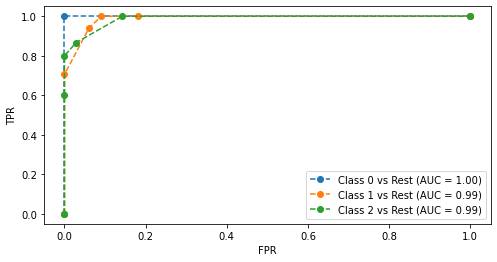

In [16]:
# make ROC plots
lbl_fmt = "Class {} vs Rest (AUC = {:.2f})"
fig,ax = plt.subplots(figsize=(8,4))
for cls in [0,1,2]:
    fpr, tpr, _ = metrics.roc_curve(im_test_tgt[:,cls], 
                                    pred_probs[:,cls])
    label = lbl_fmt.format(cls, metrics.auc(fpr,tpr))
    ax.plot(fpr, tpr, 'o--', label=label)
ax.legend()
ax.set_xlabel("FPR")
ax.set_ylabel("TPR");

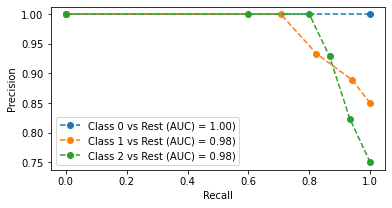

In [17]:
fig,ax = plt.subplots(figsize=(6,3))
for cls in [0,1,2]:
    prc = metrics.precision_recall_curve
    precision, recall, _ = prc(im_test_tgt[:,cls], 
                               pred_probs[:,cls])
    prc_auc = metrics.auc(recall, precision)
    label = "Class {} vs Rest (AUC) = {:.2f})".format(cls, prc_auc) 
    ax.plot(recall, precision, 'o--', label=label)
ax.legend()
ax.set_xlabel('Recall')
ax.set_ylabel('Precision');

# Multi-Class AUC:  The Hand and Till Method

In [18]:
# pseudo-code
# 1. train a model
# 2. get classification scores for each example
# 3. create a blank table for each pair of classes
#    (how tough is this pair of classes to distinguish with *this* classifier)
#    auc is not symmetric b/c 
# 4. for each pair (c_1, c_2) of classes:
#    a. find AUC of c_1 against c_2 (c_1 POS, c_2 NEG)
#    b. find AUC of c_2 against c_1 (c_2 POS, c_1 NEG)
#    c. entry for c_1, c_2 is average of those AUCs
# 5. final value is average of the entries in the table
from mlwpy_video_extras import hand_and_till_M_statistic

In [19]:
knn = neighbors.KNeighborsClassifier()
knn.fit(iris_train_ftrs, iris_train_tgt)
test_probs = knn.predict_proba(iris_test_ftrs)
hand_and_till_M_statistic(iris_test_tgt, test_probs)

0.9915032679738562

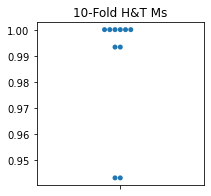

In [20]:
fig,ax = plt.subplots(1,1,figsize=(3,3))
htm_scorer = metrics.make_scorer(hand_and_till_M_statistic, 
                                 needs_proba=True)
cv_auc = skms.cross_val_score(knn, 
                              iris.data, iris.target, 
                              scoring=htm_scorer, cv=10)
sns.swarmplot(cv_auc, orient='v')
ax.set_title('10-Fold H&T Ms');

# Cumulative Response and Lift Curves

In [21]:
is_versicolor = iris.target == 1
tts_oc = skms.train_test_split(iris.data, is_versicolor, 
                               test_size=.33, random_state = 21)
(oc_train_ftrs, oc_test_ftrs, 
 oc_train_tgt,  oc_test_tgt) = tts_oc

# build, fit, predict (probability scores) for NB model
gnb = naive_bayes.GaussianNB()
prob_true = (gnb.fit(oc_train_ftrs, oc_train_tgt)
                .predict_proba(oc_test_ftrs)[:,1]) # [:,1]=="True"

In [22]:
# what is the location of the "most likely true example"?
# negate b/c we want big values first
myorder = np.argsort(-prob_true)

# cumulative sum then to percent (last value is total)
realpct_myorder = oc_test_tgt[myorder].cumsum()       
realpct_myorder = realpct_myorder / realpct_myorder[-1]

# convert counts of data into percents
N = oc_test_tgt.size
xs = np.linspace(1/N,1,N)

print(myorder[:3], realpct_myorder[:3])

[ 0 28 43] [0.05882353 0.11764706 0.17647059]


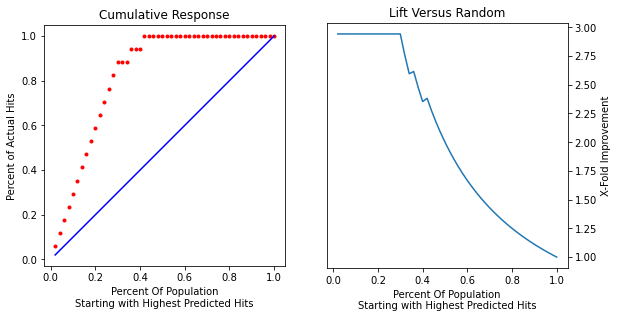

In [23]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
fig.tight_layout()

# cumulative response
ax1.plot(xs, realpct_myorder, 'r.')
ax1.plot(xs, xs, 'b-')
ax1.axes.set_aspect('equal')

ax1.set_title("Cumulative Response")
ax1.set_ylabel("Percent of Actual Hits")
ax1.set_xlabel("Percent Of Population\n" +
               "Starting with Highest Predicted Hits")

# lift
# replace divide by zero with 1.0
ax2.plot(xs, realpct_myorder / np.where(xs > 0, xs, 1))

ax2.set_title("Lift Versus Random")
ax2.set_ylabel("X-Fold Improvement") # not cross-fold!
ax2.set_xlabel("Percent Of Population\n" + 
               "Starting with Highest Predicted Hits")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right');

# Case Study: A Classifier Comparison

In [24]:
classifiers = {'base'  : dummy.DummyClassifier(strategy='most_frequent'),
               'gnb'   : naive_bayes.GaussianNB(),
               '3-NN'  : neighbors.KNeighborsClassifier(n_neighbors=10),
               '10-NN' : neighbors.KNeighborsClassifier(n_neighbors=3)}

In [25]:
# define the one_class iris problem so we don't have random ==1 around
iris_onec_ftrs = iris.data
iris_onec_tgt  = iris.target==1

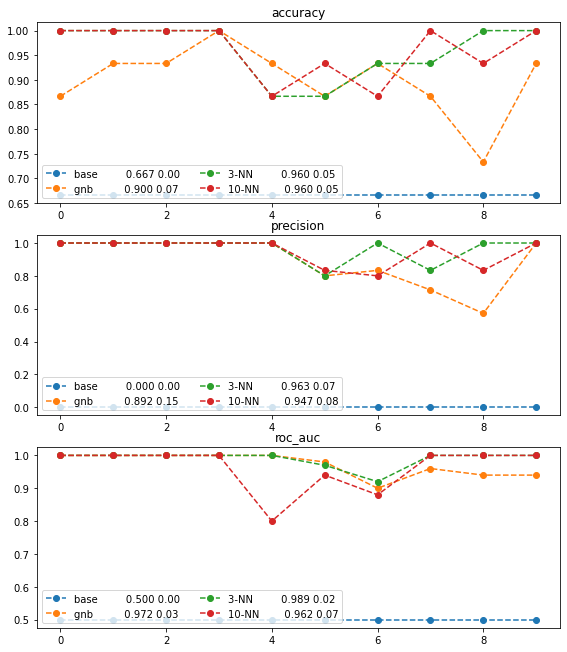

In [26]:
msrs = ['accuracy', 'precision', 'roc_auc']

fig, axes = plt.subplots(len(msrs), 1, figsize=(8, 3*len(msrs)))
fig.tight_layout()

for mod_name, model in classifiers.items():
    # abbreviate
    cvs = skms.cross_val_score
    cv_results = {msr:cvs(model, iris_onec_ftrs, iris_onec_tgt,
                          scoring=msr, cv=10) for msr in msrs}
    
    for ax, msr in zip(axes, msrs):
        msr_results = cv_results[msr]
        my_lbl = "{:12s} {:.3f} {:.2f}".format(mod_name, 
                                               msr_results.mean(), 
                                               msr_results.std())
        ax.plot(msr_results, 'o--', label=my_lbl)
        ax.set_title(msr)
        ax.legend(loc='lower left', ncol=2)

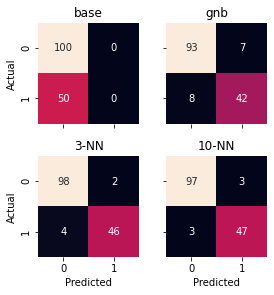

In [27]:
fig, axes = plt.subplots(2,2, figsize=(4,4), sharex=True, sharey=True)
fig.tight_layout()

for ax, (mod_name, model) in zip(axes.flat, classifiers.items()):
    preds = skms.cross_val_predict(model, 
                                   iris_onec_ftrs, iris_onec_tgt, 
                                   cv=10)
    
    cm = metrics.confusion_matrix(iris_onec_tgt, preds)
    sns.heatmap(cm, annot=True, ax=ax, 
                cbar=False, square=True, fmt="d")
    
    ax.set_title(mod_name)
    
axes[1,0].set_xlabel('Predicted')
axes[1,1].set_xlabel('Predicted')
axes[0,0].set_ylabel('Actual')
axes[1,0].set_ylabel('Actual');

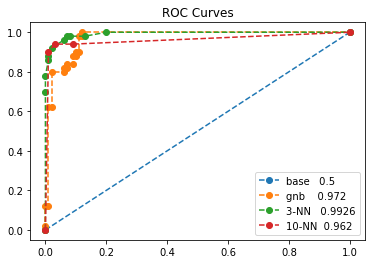

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

cv_prob_true = {} # store these for use in next cell
for mod_name, model in classifiers.items():
    cv_probs = skms.cross_val_predict(model, 
                                      iris_onec_ftrs, iris_onec_tgt, 
                                      cv=10, method='predict_proba')
    cv_prob_true[mod_name] = cv_probs[:,1]
    
    fpr, tpr, thresh = metrics.roc_curve(iris_onec_tgt, 
                                         cv_prob_true[mod_name])
    
    auc = metrics.auc(fpr, tpr)
    ax.plot(fpr, tpr, 'o--', label="{:7s}{}".format(mod_name, auc))

ax.set_title('ROC Curves')
ax.legend();

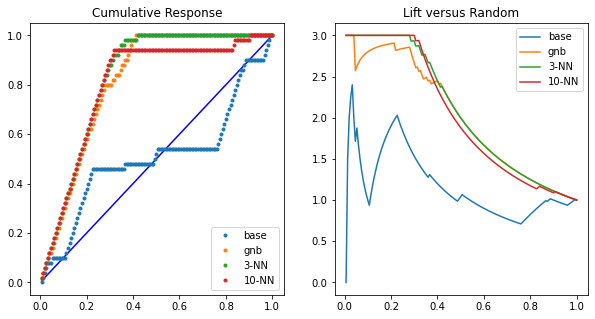

In [29]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))

N = len(iris_onec_tgt)
xs = np.linspace(1/N,1,N)

ax1.plot(xs, xs, 'b-')

for mod_name in classifiers:    
    # negate b/c we want big values first
    myorder = np.argsort(-cv_prob_true[mod_name])

    # cumulative sum then to percent (last value is total)
    realpct_myorder = iris_onec_tgt[myorder].cumsum()       
    realpct_myorder = realpct_myorder / realpct_myorder[-1]
    
    ax1.plot(xs, realpct_myorder, '.', label=mod_name)
    
    ax2.plot(xs, 
            realpct_myorder / np.where(xs > 0, xs, 1),
            label=mod_name)
ax1.legend()
ax2.legend()

ax1.set_title("Cumulative Response")
ax2.set_title("Lift versus Random");